In [142]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [44]:
import numpy as np
import pandas as pd

In [45]:
import datetime as dt

In [46]:
import warnings; warnings.simplefilter('ignore')

# Reflect Tables into SQLAlchemy ORM

In [47]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [48]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [49]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [50]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [51]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [52]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [53]:
measurement_data = engine.execute("SELECT * FROM measurement")
measurement_data.keys()
#for record in data:
#  print(record)

['id', 'station', 'date', 'prcp', 'tobs']

In [54]:
#data = engine.execute("SELECT max(date) FROM station")
station_data = engine.execute("SELECT * FROM station")
station_data.keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [55]:
#Convert max date to date format
from_date = dt.datetime(2017, 8, 23)
#Get the end date a year from the start date
to_date = from_date - dt.timedelta(days=365) 

In [56]:
# Query to retrieve the last 12 months of precipitation data and plot the results
results = session.query(Measurement.date, Measurement.prcp)\
                .filter(Measurement.date <= from_date)\
                .filter(Measurement.date > to_date)\
                .order_by(Measurement.date.desc())\
                .all()

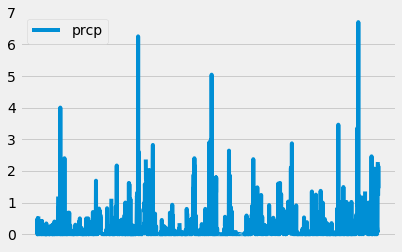

In [57]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(results)
precip_df['prcp'] = precip_df['prcp'].astype(float)

precip_df = precip_df.set_index('date')

# Sort the dataframe by date
precip_df.sort_values(by=['date'])

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot()
plt.axes().get_xaxis().set_visible(False)
plt.show()
plt.close()

In [58]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_data = pd.Series(precip_df.prcp)
precipitation_data.describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

In [59]:
# Design a query to show how many stations are available in this dataset?
station_name = session.query(Station.name)\
                .count()
print(f"There are {station_name} stations in the dataset")

There are 9 stations in the dataset


In [60]:
# The most active station which has the most number of rows
sel = [Station.name, Measurement.station, func.count(Measurement.station).label("TotalCount")]
active_station = session.query(*sel)\
                         .group_by(Measurement.station)\
                         .order_by(func.count(Measurement.station).desc())\
                         .limit(1)\
                         .all()
for record in active_station:
    (station_name, station_id, num_records) = record
    print(f"The {station_name} is the most active with {num_records} records associated with it.")

The WAIKIKI 717.2, HI US is the most active with 24948 records associated with it.


In [61]:
# List the stations and the counts in descending order.
sel = [Measurement.station, func.count(Measurement.station).label("TotalCount")]
all_stations = session.query(*sel)\
                         .group_by(Measurement.station)\
                         .order_by(func.count(Measurement.station).desc())\
                         .all()
all_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [62]:
# calculations of the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [Measurement.station, func.min(Measurement.tobs).label("LowestTemperature"), 
       func.max(Measurement.tobs).label("HighestTemperature"),
       func.avg(Measurement.tobs).label("AverageTemperature")]
active_station_details = session.query(*sel)\
                         .filter(Measurement.station == 'USC00519281')\
                         .all()
for record in active_station_details:
    (station_name, lowest_temp, higest_temp, average_temp) = record
    print(f"The lowest temperature is {lowest_temp}.")
    print(f"The highest temperature is {higest_temp}.")
    print(f"The average temperature is {average_temp}.")

The lowest temperature is 54.0.
The highest temperature is 85.0.
The average temperature is 71.66378066378067.


Text(0.5, 0, 'Temperature')

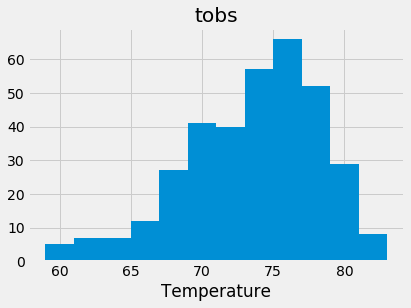

In [63]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station_one_year = session.query(Measurement.date, Measurement.tobs)\
                                 .filter(Measurement.date <= from_date)\
                                 .filter(Measurement.date > to_date)\
                                 .filter(Measurement.station == 'USC00519281')\
                                 .order_by(Measurement.date.desc())\
                                 .all()
active_station_df = pd.DataFrame(active_station_one_year, columns=['date', 'tobs'])
active_station_df.set_index('date', inplace=True)
active_station_df.hist(bins=12)
plt.xlabel('Temperature')

In [64]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs).label("LowestTemperature"), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [65]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-07-21', '2017-07-25'))

[(72.0, 78.45161290322581, 82.0)]


In [66]:
#Get the vaction stats into a dataframe
vacation_df = pd.DataFrame(calc_temps('2017-07-21', '2017-07-25'), columns=['lowtemp', 'avgtemp', 'maxtemp'])

Text(0.5, 0, 'Average Temp')

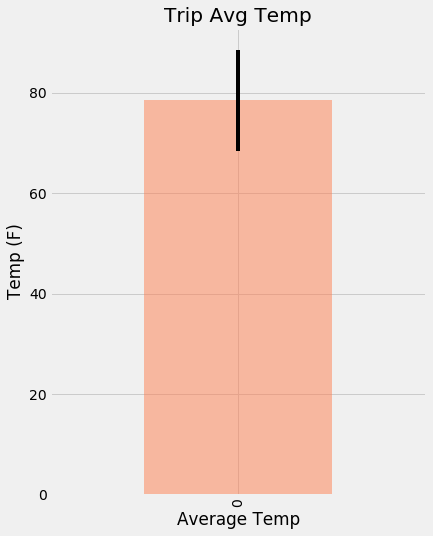

In [67]:
# Avg temp is the bar height. 
avg_temp = vacation_df.avgtemp
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
temp_diff = vacation_df.maxtemp - vacation_df.lowtemp
avg_temp.plot(kind='bar', yerr=temp_diff, figsize=(6,8), alpha=0.5, color='coral')
# Use "Trip Avg Temp" as your Title
plt.title('Trip Avg Temp')
# Use the average temperature for the y value
plt.ylabel('Temp (F)')
plt.xlabel('Average Temp')


In [68]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = dt.datetime(2017, 7, 21)
end_date = dt.datetime(2017, 7, 25)

sel = [Measurement.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp).label("TotalPrecipitation")]

vacation_prcp = session.query(*sel)\
                      .filter(Station.station == Measurement.station)\
                      .filter(Measurement.date <= end_date)\
                      .filter(Measurement.date >= start_date)\
                      .group_by(Station.name, Measurement.station, Station.latitude, Station.longitude, Station.elevation)\
                      .order_by(func.sum(Measurement.prcp).desc())\
                      .all()
vacation_prcp

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  5.9399999999999995),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  1.5),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.12),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.74),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.08),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.05),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)]

## Optional Challenge Assignment

In [135]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("07-25")

[(67.0, 76.89090909090909, 84.0)]

In [138]:
# calculate the daily normals for your trip

#the start and end date of the trip
start_date = dt.datetime(2017, 7, 21)
end_date = dt.datetime(2017, 7, 25)

# push each tuple of calculations into a list called `normals`
normals = []

# Increment by 1 day in the loop
day = dt.timedelta(days=1)

# Loop through the dates and calculate the normals for each date
while start_date <= end_date:
    normals.append(daily_normals(start_date.strftime("%m-%d")))
    start_date += day

normals   

[[(69.0, 76.9245283018868, 83.0)],
 [(69.0, 75.78846153846153, 81.0)],
 [(70.0, 76.20370370370371, 84.0)],
 [(69.0, 76.55555555555556, 81.0)],
 [(67.0, 76.89090909090909, 84.0)]]

In [139]:
#Since normals became a list of a list of tuples use nested list comprehension to sperate out the values
normal_df = pd.DataFrame([[y[0] for y in  x] for x in normals])
normal_df['tavg'] = pd.DataFrame([[y[1] for y in  x] for x in normals])
normal_df['tmax'] = pd.DataFrame([[y[2] for y in  x] for x in normals])

#Add the `trip_dates` range as the `date`
normal_df['trip_dates'] = pd.date_range(start='7/21/2017', periods=len(normal_df), freq='D')

#Rename the first column
normal_df.rename(columns = {0:'tmin'}, inplace = True)

In [140]:
# Set the `date` as index
normal_df = normal_df.set_index('trip_dates')
normal_df

,tmin,tavg,tmax
trip_dates,,,
2017-07-21,69.0,76.924528,83.0
2017-07-22,69.0,75.788462,81.0
2017-07-23,70.0,76.203704,84.0
2017-07-24,69.0,76.555556,81.0
2017-07-25,67.0,76.890909,84.0


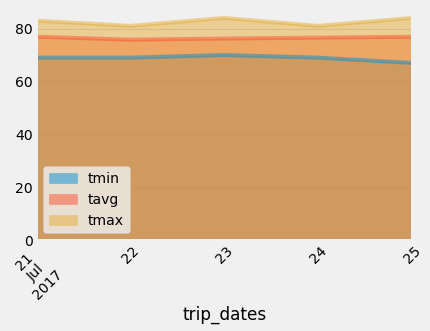

In [141]:
# Plot the daily normals as an area plot with `stacked=False`
ax = normal_df.plot(kind='area', stacked=False, rot=45)